In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn import tree, svm, preprocessing
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectFromModel, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from tabulate import tabulate

## Data import and proprocessing

In [2]:
# Import trainning and test sets
training_data = pd.DataFrame(pd.read_csv('../Downloads/npf_train.csv')).drop(['id', 'date', 'partlybad'], axis=1)
test_data = pd.DataFrame(pd.read_csv('../Downloads/npf_test_hidden.csv')).drop(['id', 'date', 'partlybad', 'class4'], axis=1)


# Make new categorical 'type' variable whose values are integers instead of strings

training_types = []
for i, x in enumerate(training_data['class4']):

    if x == 'nonevent':
        training_types.append(0)
    if x == 'Ia':
        training_types.append(1)
    if x == 'Ib':
        training_types.append(2)
    if x == 'II':
        training_types.append(3)
        

training_data['type'] = training_types

training_data['class2'] = [0 if i == 'nonevent' else 1 for i in training_data['class4']] # Make new categorical 'class2' variable whose
                                                                                        #value is 1 for 'event' and 0 for 'nonevent'

training_data = training_data.drop('class4', axis=1) # Drop redundent 'class4' variable

features = list(training_data.columns) # Define list of features from which to choose best ones for the models


features = features[:-2] # Drop variables that we aim to predict from this list


# Scale the values of the features to have zero mean and unit variance to ensure sklearn methods work properly

scaler = preprocessing.StandardScaler().fit(training_data[features])
scaler1 = preprocessing.StandardScaler().fit(test_data[features])
training_data[features] = scaler.transform(training_data[features])
test_data[features] = scaler.transform(test_data[features])



## Choosing which features to train the binary classifier on 

/Users/felixeurasto/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
/Users/felixeurasto/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


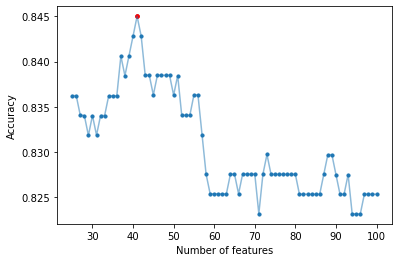

In [3]:

# Use iterative feature pruning to find optimal set of features for logistic regression model
# Logistic regression chosen here just to to find a set of good features

model = RFECV(LogisticRegression(random_state=0, max_iter=1000), step = 1, cv = 5, min_features_to_select=25)

model.fit(training_data[features], training_data['class2']) # Fit the model using training data

means = [np.mean(i) for i in model.grid_scores_] # Mean CV accururacies of models fit on different sets of features

    

probs = model.predict_proba(test_data[features])
preds = model.predict(test_data[features])

# Plot the mean accuracies of models fit on different sets of features

plt.plot([_ + 25 for _ in range(len(means))], means, alpha=0.5)

plt.scatter([_ + 25 for _ in range(len(means))], means, s=10)
plt.scatter(41, means[16], c='r', s=14)
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

binary_used = [e for i, e in enumerate(model.feature_names_in_) if model.support_[i] == True] # Save used features in list


## Choosing which features to train the multiclass classifier on 

In [ ]:
# Same procedure as with the binary classifier

model1 = RFECV(LogisticRegression(random_state=0, max_iter=1000), step = 1, cv = 5, min_features_to_select=10)
model1.fit(training_data[features], training_data['type'])


means1 = [np.mean(i) for i in model1.grid_scores_]

multiclass_used = [e for i, e in enumerate(model1.feature_names_in_) if model1.support_[i] == True]


# Plot the mean accuracies of models fit on different sets of features

plt.scatter([_ + 10 for _ in range(len(means1))], means1, s=10)
plt.plot([_ + 10 for _ in range(len(means1))], means1, alpha=0.5)
plt.scatter(means1.index(max(means1)) + 10, means1[means1.index(max(means1))], c='r', s=14)
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.savefig('logistic_accuracies_multi.png')

## Deciding which kind of model to use for the binary classification
## Considered models: logistic regression, naive Bayes, SVM, k-NN and decision tree

In [ ]:

folds = KFold(n_splits=10)

a = []
b = []
c = []
d = []
e = []


for tr, te in folds.split(training_data):
    
    model = LogisticRegression(random_state=0, max_iter=1000)
    
    model.fit(training_data[features].iloc[tr], training_data['class2'].iloc[tr])
    
    a.append(model.score(training_data[features].iloc[te], training_data['class2'].iloc[te]))
    

for tr, te in folds.split(training_data):
    
    model = GaussianNB()
    
    model.fit(training_data[features].iloc[tr], training_data['class2'].iloc[tr])
    
    b.append(model.score(training_data[features].iloc[te], training_data['class2'].iloc[te]))


for tr, te in folds.split(training_data):
    
    model = svm.SVC(kernel='rbf')
    
    model.fit(training_data[features].iloc[tr], training_data['class2'].iloc[tr])
    
    c.append(model.score(training_data[features].iloc[te], training_data['class2'].iloc[te]))
    


for tr, te in folds.split(training_data):
    
    model = KNeighborsClassifier(n_neighbors=20)
    
    model.fit(training_data[features].iloc[tr], training_data['class2'].iloc[tr])
    
    d.append(model.score(training_data[features].iloc[te], training_data['class2'].iloc[te]))



for tr, te in folds.split(training_data):
    
    model = tree.DecisionTreeClassifier()
    
    model.fit(training_data[features].iloc[tr], training_data['class2'].iloc[tr])
    
    e.append(model.score(training_data[features].iloc[te], training_data['class2'].iloc[te]))
    
    

scores = ['score', np.round(np.mean(b), 3), np.round(np.mean(a), 3), np.round(np.mean(c), 3),
          np.round(np.mean(d), 3), np.round(np.mean(e), 3)]
models = ['model', 'naive Bayes', 'logistic regression', 'SVM', 'k-NN', 'decision tree']




table = [models, scores]

table = tabulate(table, tablefmt='fancy')

print(table)


# Let's choose a logistic regression model

## Deciding which kind of model to use for the multiclass classification
## Considered models: logistic regression, naive Bayes, SVM, k-NN and decision tree

In [ ]:

folds = KFold(n_splits=10)

a = []
b = []
c = []
d = []
e = []


for tr, te in folds.split(training_data):
    
    model = LogisticRegression(random_state=0, max_iter=1000)
    
    model.fit(training_data[features].iloc[tr], training_data['type'].iloc[tr])
    
    a.append(model.score(training_data[features].iloc[te], training_data['type'].iloc[te]))
    

for tr, te in folds.split(training_data):
    
    model = GaussianNB()
    
    model.fit(training_data[features].iloc[tr], training_data['type'].iloc[tr])
    
    b.append(model.score(training_data[features].iloc[te], training_data['type'].iloc[te]))


for tr, te in folds.split(training_data):
    
    model = svm.SVC(kernel='rbf')
    
    model.fit(training_data[features].iloc[tr], training_data['type'].iloc[tr])
    
    c.append(model.score(training_data[features].iloc[te], training_data['type'].iloc[te]))
    


for tr, te in folds.split(training_data):
    
    model = KNeighborsClassifier(n_neighbors=20)
    
    model.fit(training_data[features].iloc[tr], training_data['type'].iloc[tr])
    
    d.append(model.score(training_data[features].iloc[te], training_data['type'].iloc[te]))



for tr, te in folds.split(training_data):
    
    model = tree.DecisionTreeClassifier()
    
    model.fit(training_data[features].iloc[tr], training_data['type'].iloc[tr])
    
    e.append(model.score(training_data[features].iloc[te], training_data['type'].iloc[te]))
    
    

scores = ['score', np.round(np.mean(b), 3), np.round(np.mean(a), 3), np.round(np.mean(c), 3),
          np.round(np.mean(d), 3), np.round(np.mean(e), 3)]
models = ['model', 'naive Bayes', 'logistic regression', 'SVM', 'k-NN', 'decision tree']




table = [models, scores]

table = tabulate(table, tablefmt='fancy')

print(table)


# Let's choose a logistic regression model, since REFCV cannot be used for SVM or k-NN
    

## Checking accuracy of developed models and calculating perplexity of binary model

In [ ]:


true_data = pd.DataFrame(pd.read_csv('../Downloads/npf_test.csv'))

true_types = []

for i, x in enumerate(true_data['class4']):

    if x == 'nonevent':
        true_types.append(0)
    if x == 'Ia':
        true_types.append(1)
    if x == 'Ib':
        true_types.append(2)
    if x == 'II':
        true_types.append(3)
        

true_data['type'] = true_types



model = LogisticRegression(random_state=0, max_iter=1000).fit(training_data[binary_used], training_data['class2'])
model1 = LogisticRegression(random_state=0, max_iter=1000).fit(training_data[multiclass_used], training_data['type'])


true_data['class2'] = [0 if t == 'nonevent' else 1 for t in true_data['class4']]



print('Binary accuracy: ' + str(model.score(test_data[binary_used], true_data['class2'])))
print('Multiclass accuracy: ' + str(model1.score(test_data[multiclass_used], true_data['type'])))

#0.772020725388601


#Calculating peroplexity of the binary classifier
u = [model.predict_proba(test_data[binary_used])[i][0] if model.predict(test_data[binary_used])[i] == 0 else 
    model.predict_proba(test_data[binary_used])[i][1] for i in range(test_data.shape[0])]

perp = np.exp(-np.mean([np.log(i) for i in u]))

print('Perplexity: ' + str(perp))


